In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

2024-11-27 12:21:58.113334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 12:21:59.131521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### __1. Import and data pre-processing:__
<font size=3>

For our natural language processing task, we will focus on text classification in sentiment analysis using the [IMDB movie reviews](https://keras.io/api/datasets/imdb/) dataset. To download the text reviews, click [here](http://mng.bz/0tIo).

In [2]:
# import the texts:

'''
The texts are separated into positive (25000) and negative reviews (25000).
Let's take all together to split them into train, validation, and test arrays.
'''

path = "../dataset/aclImdb/"

texts, labels = [], []

for data in ["train/", "test/"]:
    for label in ["pos/", "neg/"]:
            
        for file in os.listdir(path+data+label):
            with open(path+data+label+file, "r") as f:
                texts.append(f.read())
                
                if label == "pos/": labels.append(1)
                else: labels.append(0)

len(texts), len(labels)

(50000, 50000)

In [3]:
# vectorizing the texts to obtain their words as indexes of the "vocab" array:

vocab_size = 10000 # If vocab_size=None, TextVectorization() will consider all words from "texts"
max_len = 200 # maximum size of a sentence

vectorize = layers.TextVectorization(max_tokens=vocab_size,  
                                     standardize='lower_and_strip_punctuation', 
                                     split='whitespace',
                                     output_mode='int',
                                     output_sequence_length=max_len)

vectorize.adapt(texts)

vocab = vectorize.get_vocabulary()

# [UNK] = unknown word
print("Vocabulary size:", vectorize.vocabulary_size())
print("Top 10 vocabulary tokens:", vocab[:10])

2024-11-27 12:22:01.999126: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Vocabulary size: 10000
Top 10 vocabulary tokens: ['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']


In [4]:
# one sentence example:
i = 0
for word, vec in zip(texts[i].split(), vectorize(texts[i])):
    print(f"({vec.numpy()} - {word})", end=" ")
    

(11 - This) (7 - is) (4 - a) (53 - very) (1302 - rare) (464 - example) (5 - of) (4 - a) (18 - movie) (43 - about) (1 - transvestitism) (5 - (of) (1 - heterosexuals).) (2 - The) (20 - film) (4407 - treats) (2 - the) (6991 - taboo) (758 - theme) (38 - so) (12 - that) (55 - even) (4 - a) (810 - general) (309 - audience) (22 - not) (1289 - knowing) (5 - of) (1 - transvestitism) (31 - at) (32 - all) (77 - will) (2172 - strongly) (6415 - sympathize) (16 - with) (30 - its) (270 - main) (109 - character.) (7149 - Adrian) (1 - Pasdar) (7 - is) (53 - very) (841 - believable) (15 - as) (1 - Gerald/Geraldine) (3 - and) (3277 - shall) (22 - not) (27 - be) (2474 - forgot) (17 - for) (11 - this) (1 - brillant) (112 - acting.) (2 - The) (967 - directing) (5 - of) (1417 - Christopher) (1 - Monger) (7 - is) (53 - very) (1 - sensitively,) (8729 - treating) (137 - such) (4 - a) (852 - difficult) (1806 - issue) (177 - quite) (7191 - excellently,) (3443 - packed) (82 - into) (4 - a) (50 - good) (67 - story.

In [5]:
# (x, y) dataset:
x = vectorize(texts).numpy()
y = np.expand_dims(labels, axis=-1)

# shuffing the data:
N_sentences = len(x)

i = np.random.permutation(N_sentences)

x = x[i]
y = y[i]

texts = np.array(texts)[i]

print(f"x:{x.shape}, y:{y.shape}")

x:(50000, 200), y:(50000, 1)


In [6]:
# splitting data between train, validation and test:
N_test = int(0.1*N_sentences)
N_val = int(0.2*N_sentences)
N_train = N_sentences - (N_val + N_test)

x_train = x[:N_train]
x_val = x[N_train:N_train+N_val]
x_test = x[N_train+N_val:]

print(f"x-train:{x_train.shape}, x-val:{x_val.shape}, x-test:{x_test.shape}")

y_train = y[:N_train]
y_val = y[N_train:N_train+N_val]
y_test = y[N_train+N_val:]

print(f"y-train:{y_train.shape}, y-val:{y_val.shape}, y-test:{y_test.shape}")

x-train:(35000, 200), x-val:(10000, 200), x-test:(5000, 200)
y-train:(35000, 1), y-val:(10000, 1), y-test:(5000, 1)


In [7]:
# deleting unnecessary tensors:
del x, y, labels
del vectorize

### __2. Neural network modeling:__

In [8]:
embed_dim = 10

In = keras.Input((x_train.shape[1], ))

x = layers.Embedding(vocab_size, embed_dim)(In)

x = layers.Flatten()(x)

x = layers.Dense(400, activation="relu")(x)

x = layers.Dense(40, activation="relu")(x)

Out = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=In, outputs=Out)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 10)        │       100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │       800,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        16,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 916,481 (3.50 MB)

 Trainable params: 916,481 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

### __3. Model compilation:__

In [9]:
model.compile(optimizer="Adamax", loss="binary_crossentropy", metrics=["acc"])

### __4. Train and validation__   

### __5. Final training__    

In [10]:
report = model.fit(x=x_train, y=y_train, batch_size=40, epochs=10)

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.5863 - loss: 0.6439
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.8689 - loss: 0.3098
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9171 - loss: 0.2157
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9493 - loss: 0.1458
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9770 - loss: 0.0824
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9885 - loss: 0.0446
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9939 - loss: 0.0243
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9983 - loss: 0.0099
Epoch 9/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9992 - loss: 0.0046
Epoch 10/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9997 - loss: 0.0019


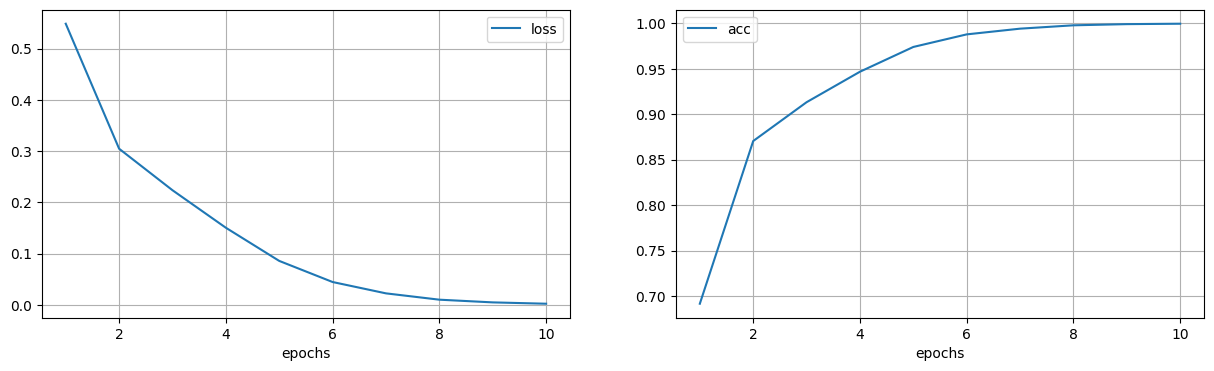

In [11]:
loss = report.history['loss']
acc = report.history['acc']

epochs = np.linspace(1, len(loss), len(loss))

fig, ax = plt.subplots(1, 2, figsize=(15,4))

ax[0].plot(epochs, loss, label="loss")
ax[1].plot(epochs, acc, label="acc")

for i in range(2):
    ax[i].set_xlabel("epochs")
    ax[i].legend()
    ax[i].grid()

plt.show()

### __6. Test evaluation__:

In [12]:
model.evaluate(x_test, y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - acc: 0.8348 - loss: 1.0488


[1.0661499500274658, 0.8356000185012817]

In [13]:
y_pred = model.predict(x_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [14]:
# list of indexes to sentence: 
idx = 1

label = "positive" if y_test[idx] == 1 else "negative"
pred_label = "positive" if y_pred[idx] >= 0.5 else "negative"

print("label:", label)
print("prediction:", pred_label, "\n")

for i in x_test[idx]:
    print(vocab[i], end=" ")
    

label: negative
prediction: negative 

when this cartoon first aired i was under the impression that it would be at least half way descent boy was i wrong i must admit watching this cartoon is almost as painful as watching batman and robin with george clooney all those years ago i watched a few episodes and two of them had batman literally get his ass kicked left and right by the penguin who fought like jet li and beat the crap out of batman and i watched another episode where batman got his butt kicked again by the joker who apparently was using jackie chan moves while flipping in the air like a ninja since when were the joker or the penguin ever a match for batman and worse yet when were joker and penguin kung fu counterparts of jackie chan and jet li its truly embarrassing depressing and sad the way the image of batman is portrayed in this show the animation is awful and the dialog is terrible being a batman fan since my [UNK] i can honestly and strongly advise you to stay away and 

### __7. Saving the model__:
<font size=3>
    
For model __loading__, see [2.3-handson-loading_model](../2-over_vs_underfitting/2.3-handson-loading_model.ipynb).